In [69]:
import mglearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

# 決定木
決定木ではYes/Noで答えられる質問で構成された階層的な木構造を学習する

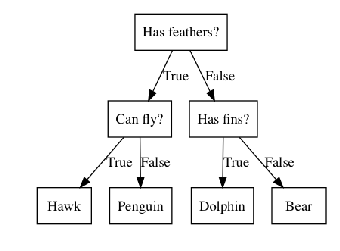

In [3]:
mglearn.plots.plot_animal_tree()

### 2次元クラスの分類データセットを用いた決定木の構築家庭の検証

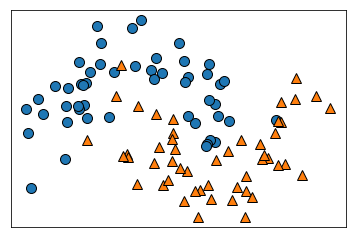

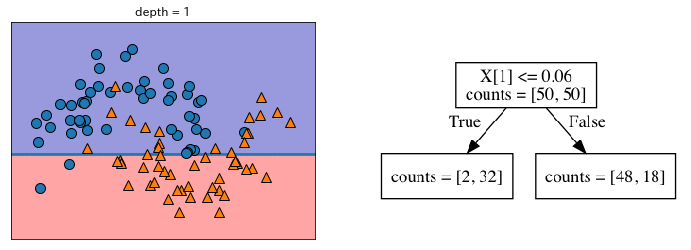

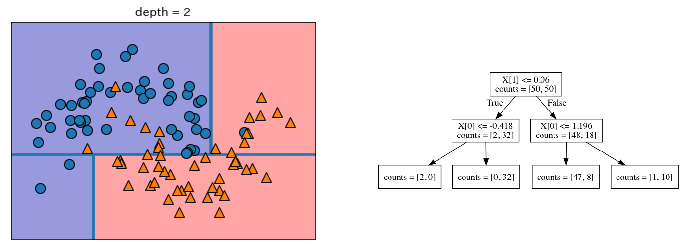

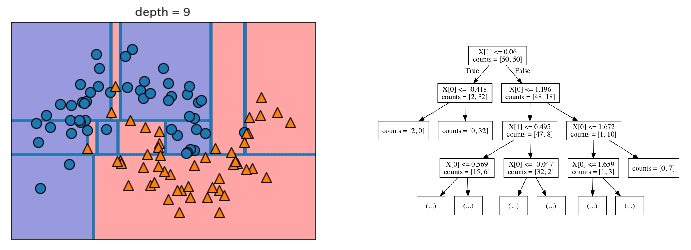

In [4]:
#このデータはそれぞれ75点あるデータポイントからなる2つの半月形を組み合わせたような形
mglearn.plots.plot_tree_progressive()

決定木を構築する際、アルゴリズムはすべての可能なテストの中から、目的変数に対して最も情報量の多いものを選ぶ。最初のテストではx[1] =0.06で水平にデータセットを分割することが最も情報量が多く、クラス0とクラス1を最もよく分割する。頂点ノード(root)はデータセット全体つまり、クラス0に属する75点とクラス1に属する75点を示す。あるデータがx[1] <= 0.06に対して真の場合は左側のノードに割り当てられ、このノードにはクラス0が2点、クラス1が32点ある。x[1] <= 0.06に対して偽であれば、右側のノードに割り当てられ、このノードにはクラス0が48点で、クラス1が18点である。  
このプロセスを再帰的に繰り返すと2分木による決定木が得られる。  

決定木に含まれるデータが一つしかない場合(=葉がpure)になるまで分割を続けると、モデルが複雑すぎて、訓練データに対して過剰適合を引き起こす。  
過剰適合を防ぐ戦略には以下の二つがある
- 事前枝刈り(pre-pruning)：木の構築過程を事前にとめる
- 事後枝刈り(post-pruning)：木を構築した後に、情報量のすくない木を削除する

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

print('Data shape: {}'.format(cancer.data.shape))

Data shape: (569, 30)


In [20]:

X_train,X_test,y_train,y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train,y_train)
print('Accurancy on training set: {:,.3f}'.format(tree.score(X_train,y_train)))
print('Accurancy on test set: {:,.3f}'.format(tree.score(X_test,y_test)))

Accurancy on training set: 1.000
Accurancy on test set: 0.937


木の深さ(depth)を制御していないので、訓練データに過剰適合していることが分かる。

In [13]:
tree = DecisionTreeClassifier(random_state=0,max_depth=4)
tree.fit(X_train,y_train)
print('Accurancy on training set: {:,.3f}'.format(tree.score(X_train,y_train)))
print('Accurancy on test set: {:,.3f}'.format(tree.score(X_test,y_test)))

Accurancy on training set: 0.988
Accurancy on test set: 0.951


木の深さ(max_depth=4)を制限することで、過剰適合が抑制され、訓練データの精度は下がったが、テストデータの精度が上がった。

### 決定木の解析

In [15]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
                feature_names=cancer.feature_names, impurity=False, filled=True)

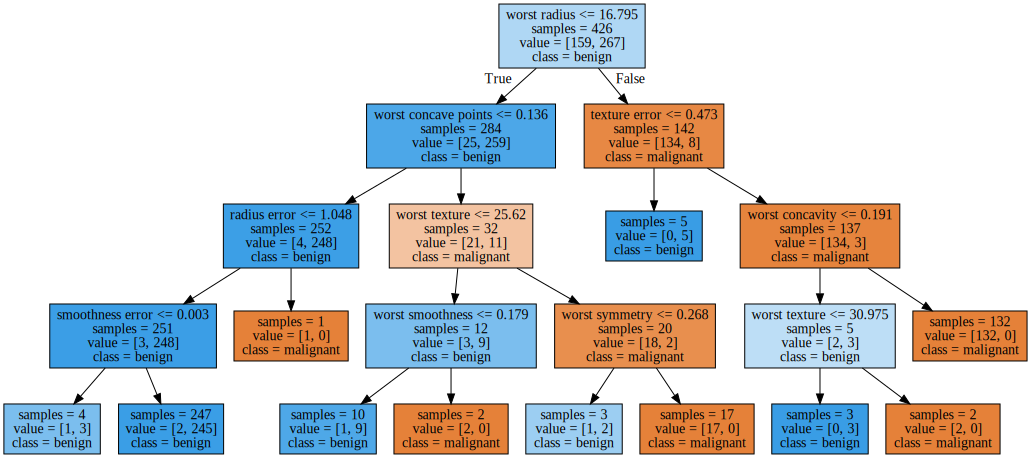

In [18]:
import graphviz
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

決定木の検証をするよい方法は大多数のデータがたどるパスを見つけることだ。  
例えば、worst radius <=16.795が偽の場合には8のbenign(良性)と134のmalignant(悪性)が割り当てられる。こちら側のノードはより細かい識別で8個の良性と134の悪性を振り分けることになる

### 特徴量解析
決定木全体を見るのは大変なので、決定木の挙動を要約する特性値として**特徴量の重要度(feature importance)**がある

In [22]:
print('Feature importance :\n {}'.format(tree.feature_importances_))

Feature importance :
 [0.         0.00752597 0.         0.         0.00903116 0.
 0.00752597 0.         0.         0.         0.00975731 0.04630969
 0.         0.00238745 0.00231135 0.         0.         0.
 0.         0.00668975 0.69546322 0.05383211 0.         0.01354675
 0.         0.         0.01740312 0.11684357 0.01137258 0.        ]


In [31]:
feature_importance = pd.DataFrame({
    'importance':tree.feature_importances_},
    index= cancer.feature_names)

,importance
mean radius,0.000000
mean texture,0.007526
mean perimeter,0.000000
mean area,0.000000
mean smoothness,0.009031
mean compactness,0.000000
mean concavity,0.007526
mean concave points,0.000000
mean symmetry,0.000000
mean fractal dimension,0.000000


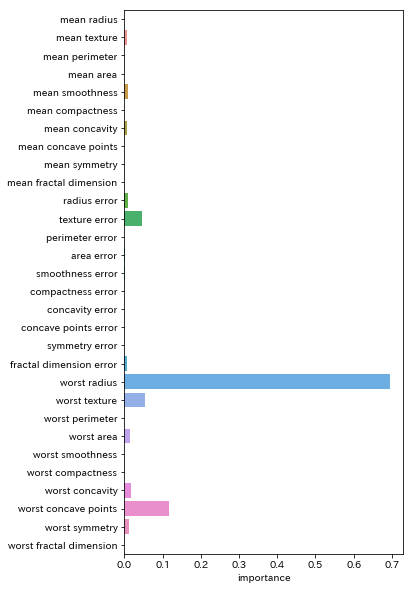

In [60]:
plt.figure(figsize=(5,10))
sns.barplot(x=feature_importance.importance,y=feature_importance.index,data=feature_importance)

最初の分岐で用いた特徴量であるworst radiusが群を抜いて重要な特徴量であることが分かる。これは最初の分岐で大半のクラスを分類できたことと一致する。  
線形モデルの係数と異なり、重要度の特徴量は常に正の値であり、特徴量がどのクラスを示しているかをエンコードしているわけではない。つまり、worst radisuが重要だと教えてくれるが、これの値が大きい(反対に小さいと)良性になるか悪性になるかを教えてくれるわけではない

Feature importances: [0. 1.]


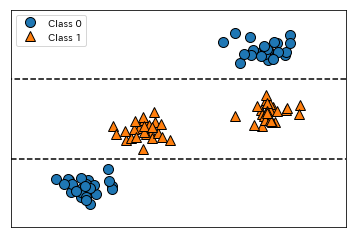

In [61]:
tree = mglearn.plots.plot_tree_not_monotone()

この場合x軸方向の情報(x[1])だけでy軸方向の情報(x[0])は使われていない。しかし、決定境界は出力に対して単調ではない。
つまりx[1]が大きいとクラス0になり、小さいとクラス1になるということは言えない